In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim



from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving archive.zip to archive.zip


In [2]:
!unzip archive.zip -d archive/    #catanddog 폴더 만들어 압축 풀기

Archive:  archive.zip
   creating: archive/archive/test/
   creating: archive/archive/test/no/
  inflating: archive/archive/test/no/melanoma_9605.jpg  
  inflating: archive/archive/test/no/melanoma_9606.jpg  
  inflating: archive/archive/test/no/melanoma_9607.jpg  
  inflating: archive/archive/test/no/melanoma_9608.jpg  
  inflating: archive/archive/test/no/melanoma_9609.jpg  
  inflating: archive/archive/test/no/melanoma_9610.jpg  
  inflating: archive/archive/test/no/melanoma_9611.jpg  
  inflating: archive/archive/test/no/melanoma_9612.jpg  
  inflating: archive/archive/test/no/melanoma_9613.jpg  
  inflating: archive/archive/test/no/melanoma_9614.jpg  
  inflating: archive/archive/test/no/melanoma_9615.jpg  
  inflating: archive/archive/test/no/melanoma_9616.jpg  
  inflating: archive/archive/test/no/melanoma_9617.jpg  
  inflating: archive/archive/test/no/melanoma_9618.jpg  
  inflating: archive/archive/test/no/melanoma_9619.jpg  
  inflating: archive/archive/test/no/melanoma_9620

In [3]:
data_path = 'archive/archive/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([300,300]),
                    transforms.RandomResizedCrop(256),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=2,
    shuffle=True
)

print(len(train_dataset))

1000


In [4]:
test_path = 'archive/archive/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(256),
                    transforms.CenterCrop(256),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

300


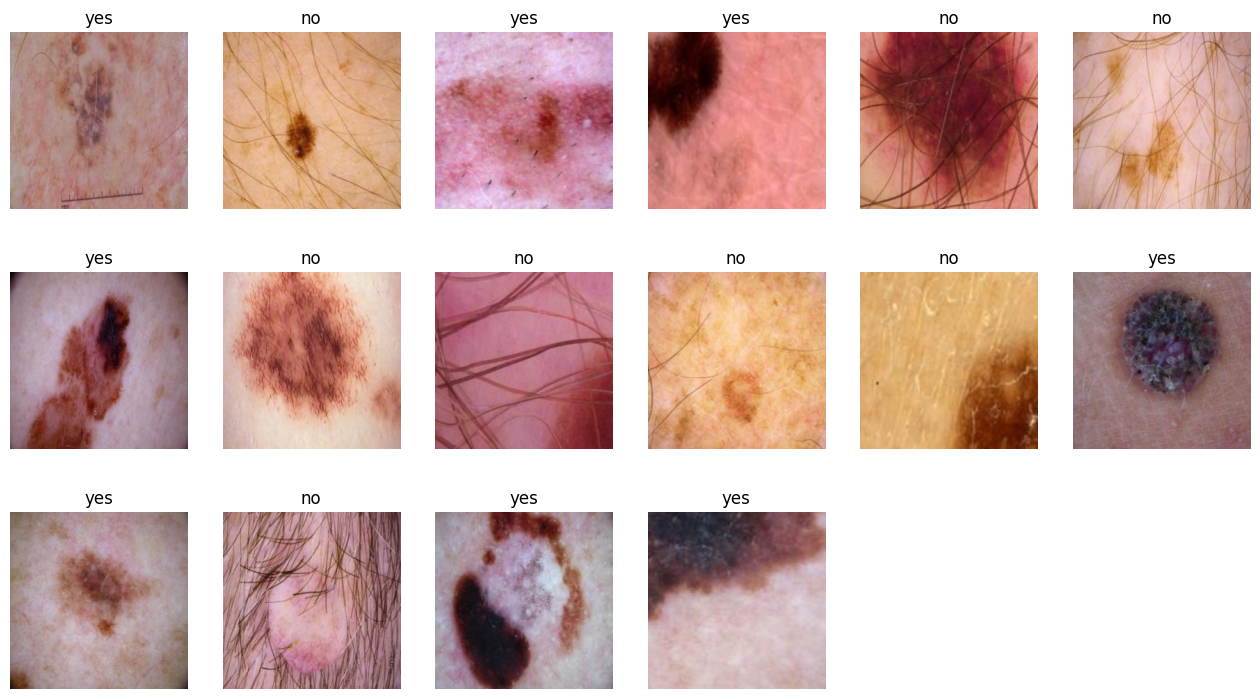

In [5]:
samples, labels = next(iter(train_loader))
classes = {0:'no' ,1:'yes'}
fig = plt.figure(figsize=(16,24))
for i in range(16):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=254016, out_features=800)
        self.drop1 = nn.Dropout(0.30)
        self.fc2 = nn.Linear(in_features=800, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.fc3(out)  
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.0001;
model = FashionCNN();
model.to(device)


criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=254016, out_features=800, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=800, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


In [8]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('archive/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [9]:
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/9
----------
Loss: 3.0238 Acc: 0.8140

Epoch 1/9
----------
Loss: 1.6669 Acc: 0.8720

Epoch 2/9
----------
Loss: 1.6211 Acc: 0.8490

Epoch 3/9
----------
Loss: 0.9585 Acc: 0.8820

Epoch 4/9
----------
Loss: 0.7357 Acc: 0.8660

Epoch 5/9
----------
Loss: 0.5344 Acc: 0.8920

Epoch 6/9
----------
Loss: 0.5246 Acc: 0.8740

Epoch 7/9
----------
Loss: 0.3521 Acc: 0.8930

Epoch 8/9
----------
Loss: 0.3495 Acc: 0.8840

Epoch 9/9
----------
Loss: 0.3311 Acc: 0.8920

Training complete in 2m 4s
Best Acc: 0.893000


In [10]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('archive/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history



In [11]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['archive/00.pth', 'archive/01.pth', 'archive/02.pth', 'archive/03.pth', 'archive/04.pth', 'archive/05.pth', 'archive/06.pth', 'archive/07.pth', 'archive/08.pth', 'archive/09.pth']
Loading model archive/00.pth
Acc: 0.6200

Loading model archive/01.pth
Acc: 0.7233

Loading model archive/02.pth
Acc: 0.6833

Loading model archive/03.pth
Acc: 0.5800

Loading model archive/04.pth
Acc: 0.6333

Loading model archive/05.pth
Acc: 0.6933

Loading model archive/06.pth
Acc: 0.6367

Loading model archive/07.pth
Acc: 0.7300

Loading model archive/08.pth
Acc: 0.6767

Loading model archive/09.pth
Acc: 0.7500

Validation complete in 0m 51s
Best Acc: 0.750000


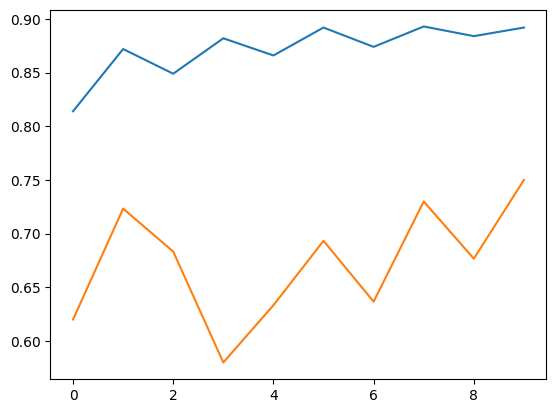

In [12]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

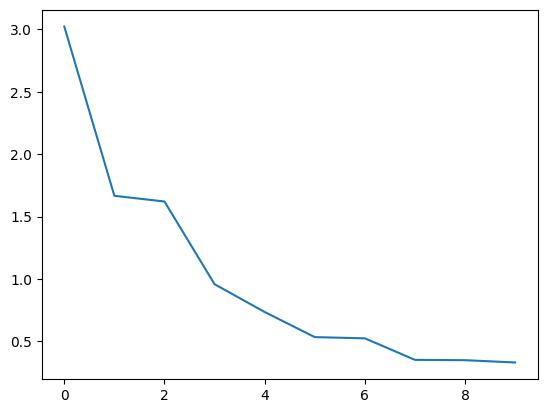

In [13]:
plt.plot(train_loss_hist)
plt.show()

In [28]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

In [29]:
classes = {0:'no',1:'yes'}

# dataiter=iter(test_loader)  
# images,labels=dataiter.next()  
images,labels=next(iter(test_loader))
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(16):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

RuntimeError: ignored

In [14]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

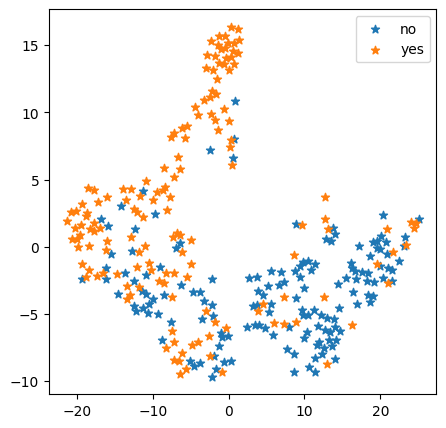

In [16]:
plt.figure(figsize=(5, 5))
name = ["no","yes"]
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='*', label=label)

plt.legend()
plt.show()